## Imports

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchsummary import summary

## Change to Cuda

In [2]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(f"Using {device} device")
device = torch.device("cpu")

## Definition of Neural Network Class

In [3]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 14, (3, 3), padding=1),         # 14, 28 x 28
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                        # 14, 14 x 14
            nn.Dropout(0.2),
            nn.Conv2d(14, 7, (3, 3), padding=1),         #  7, 14 x 14
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                        #  7,  7 x  7
            nn.Dropout(0.2),
            nn.Flatten(),                                #  343
            nn.Linear(343, 28),
            nn.ReLU(),
            nn.Linear(28, 10)
        )

    def forward(self, x):
        logits = self.main(x)
        return logits

In [4]:
training_data = datasets.FashionMNIST(
    root='~/.pytorch/F_MNIST_data/',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='~/.pytorch/F_MNIST_data/',
    train=False,
    download=True,
    transform=ToTensor()
)

trainloader = DataLoader(training_data, batch_size=64, shuffle=True)
validloader = DataLoader(test_data, batch_size=64, shuffle=True)

class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

In [5]:
cnn_model = ConvolutionalNeuralNetwork()

In [6]:
summary(cnn_model, (1, 28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Conv2d: 2-1                       [-1, 14, 28, 28]          140
|    └─ReLU: 2-2                         [-1, 14, 28, 28]          --
|    └─MaxPool2d: 2-3                    [-1, 14, 14, 14]          --
|    └─Dropout: 2-4                      [-1, 14, 14, 14]          --
|    └─Conv2d: 2-5                       [-1, 7, 14, 14]           889
|    └─ReLU: 2-6                         [-1, 7, 14, 14]           --
|    └─MaxPool2d: 2-7                    [-1, 7, 7, 7]             --
|    └─Dropout: 2-8                      [-1, 7, 7, 7]             --
|    └─Flatten: 2-9                      [-1, 343]                 --
|    └─Linear: 2-10                      [-1, 28]                  9,632
|    └─ReLU: 2-11                        [-1, 28]                  --
|    └─Linear: 2-12                      [-1, 10]                  290
Total par

## Sample Check

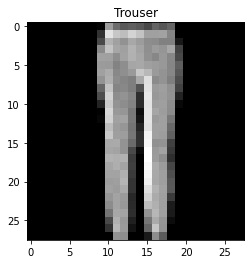

In [7]:
image, label = next(iter(trainloader))  # Get a random batch of 64 images
i = np.random.randint(0, 64)            # Choose one image at random
plt.imshow(image[i, 0], cmap='gray')    # Plot
plt.title(class_labels[label[i]]);

## Prediction Function and Prediction Check before Training

In [8]:
def plot_prediction(image, label, predictions):
    """Plot network predictions with matplotlib."""
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)  # Plot
    ax1.imshow(image[0], cmap='gray')
    ax1.axis('off')   
    ax1.set_title(class_labels[label])
    ax2.barh(np.arange(10), predictions.data.numpy().squeeze())   
    ax2.set_title("Predictions")
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(class_labels)
    ax2.set_xlim(0, 1)
    plt.tight_layout();

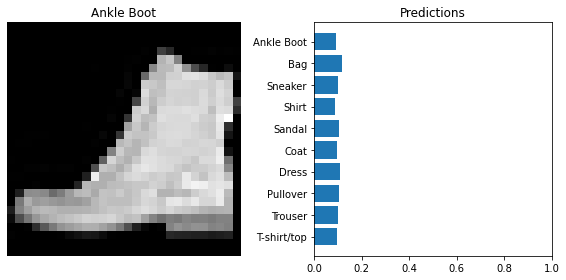

In [9]:
# Test on training images (run as many times as you like!)
image, label = next(iter(trainloader))        # Get a random batch of 64 images
cnn_model.to(device)
predictions = cnn_model(image)  # Get first image and predict it
predictions = nn.Softmax(dim=1)(predictions)  # Coerce predictions to probabilities using Softmax()
plot_prediction(image[0], label[0], predictions[0])

In [10]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        train_batch_acc = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            # X = X.to(device)
            # y = y.to(device)
            y_hat = model(X)  # forward pass to get output
            _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
            loss = criterion(y_hat, y)  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
            train_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        train_loss.append(train_batch_loss / len(trainloader))
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # Validation
        model.eval()
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                # X = X.to(device)
                # y = y.to(device)
                y_hat = model(X)  # forward pass to get output
                _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}."
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
            
    print("\nTraining ended.")

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

In [12]:
trainer(cnn_model, criterion, optimizer, trainloader, validloader, epochs=20, verbose=True)

Epoch 1: Train Loss: 0.739. Valid Loss: 0.510. Train Accuracy: 0.73.Valid Accuracy: 0.81.
Epoch 2: Train Loss: 0.492. Valid Loss: 0.453. Train Accuracy: 0.82.Valid Accuracy: 0.83.
Epoch 3: Train Loss: 0.442. Valid Loss: 0.397. Train Accuracy: 0.84.Valid Accuracy: 0.86.
Epoch 4: Train Loss: 0.416. Valid Loss: 0.382. Train Accuracy: 0.85.Valid Accuracy: 0.87.
Epoch 5: Train Loss: 0.395. Valid Loss: 0.356. Train Accuracy: 0.86.Valid Accuracy: 0.87.
Epoch 6: Train Loss: 0.381. Valid Loss: 0.346. Train Accuracy: 0.86.Valid Accuracy: 0.88.
Epoch 7: Train Loss: 0.367. Valid Loss: 0.341. Train Accuracy: 0.87.Valid Accuracy: 0.88.
Epoch 8: Train Loss: 0.360. Valid Loss: 0.334. Train Accuracy: 0.87.Valid Accuracy: 0.88.
Epoch 9: Train Loss: 0.353. Valid Loss: 0.326. Train Accuracy: 0.87.Valid Accuracy: 0.88.
Epoch 10: Train Loss: 0.342. Valid Loss: 0.325. Train Accuracy: 0.88.Valid Accuracy: 0.88.
Epoch 11: Train Loss: 0.337. Valid Loss: 0.326. Train Accuracy: 0.88.Valid Accuracy: 0.88.
Epoch 12

## Prediction Check After Training

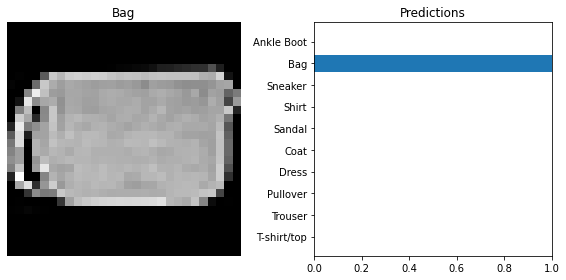

In [13]:
image, label = next(iter(trainloader))        # Get a random batch of 64 images
predictions = cnn_model(image)  # Get first image, and predict it
predictions = nn.Softmax(dim=1)(predictions)  # Coerce predictions to probabilities using Softmax()
plot_prediction(image[0], label[0], predictions[0])

## Model Save

In [14]:
torch.save(cnn_model.state_dict(), 'cnn_model_weights.pth')
torch.save(cnn_model, 'cnn_model.pth')

## Checking model save, load

In [15]:
model = torch.load('cnn_model.pth')

In [16]:
trainer(model, criterion, optimizer, trainloader, validloader, epochs=2, verbose=True)

Epoch 1: Train Loss: 0.292. Valid Loss: 0.288. Train Accuracy: 0.89.Valid Accuracy: 0.90.
Epoch 2: Train Loss: 0.291. Valid Loss: 0.288. Train Accuracy: 0.89.Valid Accuracy: 0.90.

Training ended.
